<a href="https://colab.research.google.com/github/rrankawat/pytorch-cnn/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key characteristics of CIFAR-10:
* Size: 60,000 images.
* Dimensions: Each image is 32 pixels by 32 pixels.
* Color: Images are in color, with RGB channels.
* Classes: 10 distinct categories of objects.
* Data Split: A standard configuration uses 50,000 images for training and 10,000 images for testing.
### Examples of the 10 classes:
* Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, and Truck.

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##### Transform, Data Loading & Converting To Batches

In [56]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [57]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

##### CNN Model

In [58]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3×32×32  -> 16×32×32
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16×16×16 -> 32×16×16
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32×8×8   -> 64×8×8
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 64x4x4 -> 128x4x4
        self.bn4 = nn.BatchNorm2d(128)


        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Conv1 + Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Conv2 + Pool
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Conv3 + Pool
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Conv4 + Pool
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # Flatten
        x = x.view(-1, 128 * 2 * 2)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

##### Random Seeds and Model Instance

In [59]:
torch.manual_seed(41)
model = CIFARConvNet()

##### Loss & Optimizer

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### Time Function

In [61]:
def totalTime(start_time):
  current_time = time.time()
  total_time = (current_time - start_time) / 60
  return round(total_time, 2)

##### Model Training & Testing

In [62]:
# Variables to track things
epochs = 30
train_losses = []
train_correct = []
test_losses = []
test_correct = []

In [63]:
# -------------------
# Training function
# -------------------
def train(epoch, model, train_loader, criterion, optimizer):
  model.train()

  trn_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    trn_corr += (predicted == y_train).sum()

    # Back-propagation & Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b % 250 == 0:
      print(f"Epoch: {epoch + 1} [{b * len(X_train)}/{len(train_loader.dataset)} "
            f"({100. * b / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

  print("\n")
  train_losses.append(loss)
  train_correct.append(trn_corr)

In [64]:
# -------------------
# Test function
# -------------------
def test(model, test_loader, criterion, optimizer):
  model.eval()
  tst_corr = 0

  with torch.no_grad():
    for X_test, y_test in test_loader:
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

In [65]:
# Training Run Epochs
start_time = time.time()

for epoch in range(epochs):
  train(epoch, model, train_loader, criterion, optimizer)

print(f'Time taken: {totalTime(start_time)} minutes!')

Epoch: 1 [25000/50000 (50%)]	Loss: 1.414925
Epoch: 1 [50000/50000 (100%)]	Loss: 1.385965


Epoch: 2 [25000/50000 (50%)]	Loss: 1.172609
Epoch: 2 [50000/50000 (100%)]	Loss: 1.193022


Epoch: 3 [25000/50000 (50%)]	Loss: 1.120958
Epoch: 3 [50000/50000 (100%)]	Loss: 1.162348


Epoch: 4 [25000/50000 (50%)]	Loss: 0.931967
Epoch: 4 [50000/50000 (100%)]	Loss: 1.043544


Epoch: 5 [25000/50000 (50%)]	Loss: 1.060683
Epoch: 5 [50000/50000 (100%)]	Loss: 1.154295


Epoch: 6 [25000/50000 (50%)]	Loss: 0.882245
Epoch: 6 [50000/50000 (100%)]	Loss: 0.810037


Epoch: 7 [25000/50000 (50%)]	Loss: 0.869381
Epoch: 7 [50000/50000 (100%)]	Loss: 1.124540


Epoch: 8 [25000/50000 (50%)]	Loss: 0.882398
Epoch: 8 [50000/50000 (100%)]	Loss: 0.705869


Epoch: 9 [25000/50000 (50%)]	Loss: 0.830727
Epoch: 9 [50000/50000 (100%)]	Loss: 0.853536


Epoch: 10 [25000/50000 (50%)]	Loss: 0.767046
Epoch: 10 [50000/50000 (100%)]	Loss: 0.977666


Epoch: 11 [25000/50000 (50%)]	Loss: 0.852064
Epoch: 11 [50000/50000 (100%)]	Loss: 0.7158

In [66]:
# Testing Run Epochs
start_time = time.time()

for epoch in range(epochs):
  test(model, test_loader, criterion, optimizer)

print(f'Time taken: {totalTime(start_time)} minutes!')

Time taken: 2.8 minutes!


##### Plots

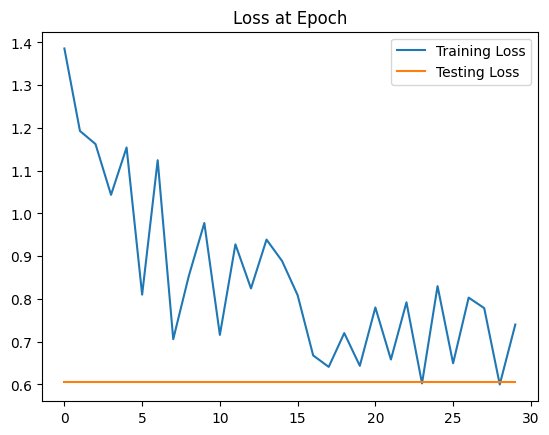

In [67]:
# ------------------------
# Plot the loss at each Epoch
# ------------------------
plt.plot([loss.detach().numpy() for loss in train_losses], label='Training Loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

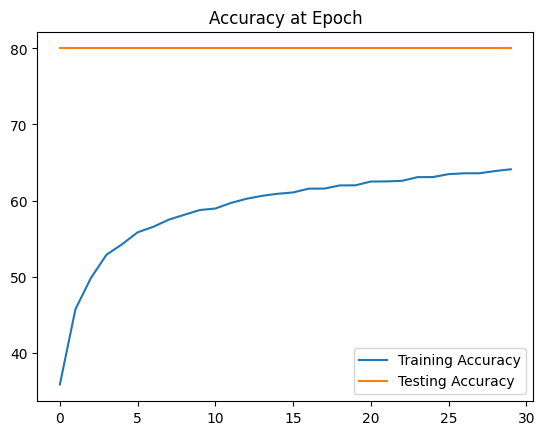

In [68]:
# --------------------------------------------
# Plot the accuracy at the end of each Epoch
# --------------------------------------------
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

##### Test Accuracy

In [69]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [70]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [71]:
# Test for correct
correct.item() / len(test_data) * 100
print(f'Test Accuracy: {round(correct.item()/len(test_data) * 100, 2)}%')

Test Accuracy: 79.99%


##### Test on New Images

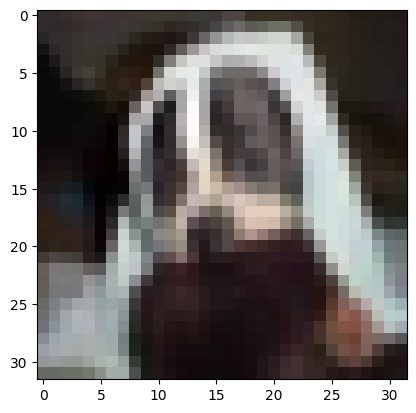

In [72]:
# Taking an Test Image 1
test_image1 = test_data[4143][0]
# Unnormalize the image
test_image1 = test_image1 * 0.5 + 0.5
plt.imshow(test_image1.permute(1, 2, 0))

In [73]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output = model(test_image1.view(1, 3, 32, 32))

# Check the new prediction
classes[output.argmax()]

'dog'

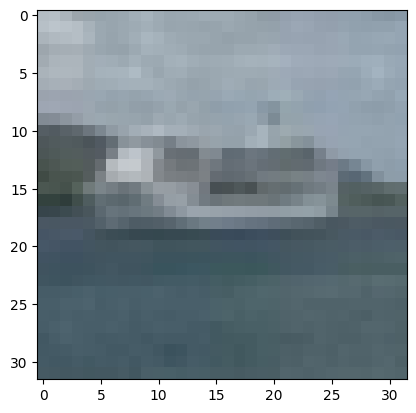

In [74]:
# Taking an Test Image 2
test_image1 = test_data[3331][0]
# Unnormalize the image
test_image1 = test_image1 * 0.5 + 0.5
plt.imshow(test_image1.permute(1, 2, 0))

In [75]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output = model(test_image1.view(1, 3, 32, 32))

# Check the new prediction
classes[output.argmax()]

'ship'